Import all the needed libraries

In [2]:
!pip install tensorflow kaggle keras scikit-learn visualkeras

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image as mpimg
import matplotlib as mpl
import seaborn as sns
from scipy.io import loadmat
from skimage import color
from skimage import io
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
import os
import time
import itertools
from __future__ import absolute_import
from __future__ import print_function
from datetime import timedelta
import h5py
import keras
import visualkeras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
import sklearn
from sklearn import neighbors, metrics
from PIL import ImageFont

np.random.seed(20)
%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 4.0)

In [4]:
TENSORBOARD_SUMMARIES_DIR = '/tmp/svhn_classifier_logs'

The following code is used to convert the images from rgb to greyscale

In [5]:
def rgb2gray(images):
    return np.expand_dims(np.dot(images, [0.2990, 0.5870, 0.1140]), axis=3)

In [6]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix', cmap=plt.cm.tab20b):
    """
    This function prints and plots the confusion matrix. 
    Normalization can be applied by setting normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm. sum (axis=1)[:, np.newaxis] 
        print("Normalized confusion matrix")
    else:    
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product (range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j]> thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

The following code gets used to plot the images as a terminal output

In [7]:
def plot_images(img, labels, nrows, ncols):
    """ Plot nrows x ncols images
    """
    fig, axes = plt.subplots(nrows, ncols)
    for i, ax in enumerate(axes.flat): 
        if img[i].shape == (32, 32, 3):
            ax.imshow(img[i])
        else:
            ax.imshow(img[i,:,:,0])
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_title(labels[i])

In [8]:
def get_batch(X, y, batch_size=512):
    for i in np.arange(0, y.shape[0], batch_size):
        end = min(X.shape[0], i + batch_size)
        yield(X[i:end],y[i:end])

In [9]:
def prepare_log_dir():
    '''Clears the log files then creates new directories to place
        the tensorbard log file.''' 
    if tf.gfile.Exists(TENSORBOARD_SUMMARIES_DIR):
        tf.gfile.DeleteRecursively(TENSORBOARD_SUMMARIES_DIR)
    tf.gfile.MakeDirs(TENSORBOARD_SUMMARIES_DIR)

The following code loads the data from the .mat file into numpy arrays

In [10]:
def load_data(path):
    """ Helper function for loading a MAT-File"""
    data = loadmat(path)
    return data['X'], data['y']

X_train, y_train = load_data('train_32x32.mat')
X_test, y_test = load_data('test_32x32.mat')

print("Training Set", X_train.shape, y_train.shape)
print("Test Set", X_test.shape, y_test.shape)

Training Set (32, 32, 3, 73257) (73257, 1)
Test Set (32, 32, 3, 26032) (26032, 1)


The following code gets used to transpose the arrays and calculate the total number of images

In [11]:
X_train, y_train = X_train.transpose((3,0,1,2)), y_train[:,0]
X_test, y_test = X_test.transpose((3,0,1,2)), y_test[:,0]

print("Training Set", X_train.shape)
print("Test Set", X_test.shape)
print('')

num_images = X_train.shape[0] + X_test.shape[0]

print("Total Number of Images", num_images)

Training Set (73257, 32, 32, 3)
Test Set (26032, 32, 32, 3)

Total Number of Images 99289


Plotting some training images

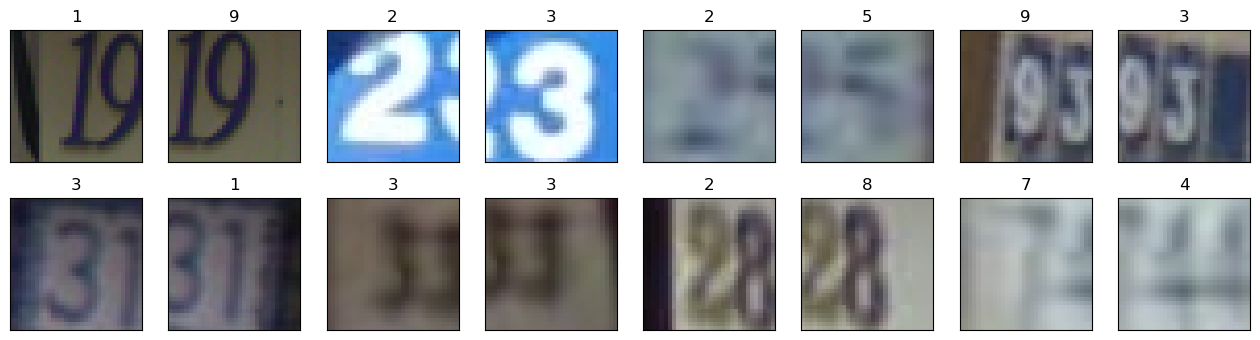

In [12]:
plot_images(X_train, y_train, 2, 8)

Plotting some test images

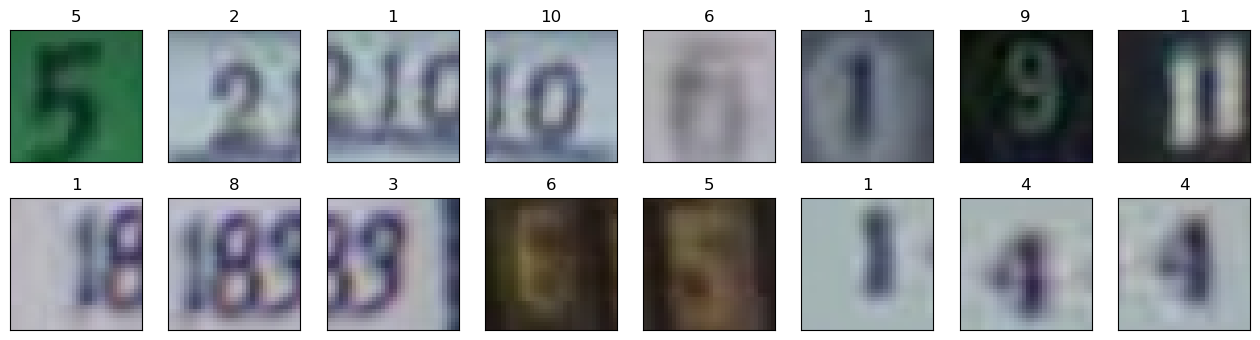

In [13]:
plot_images(X_test, y_test, 2, 8)

Rename the 10th value to 0

In [14]:
y_train[y_train == 10] = 0
y_test[y_test == 10] = 0
print(np.unique(y_train))
print(np.unique(y_test))

[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]


Verify the shat of the label arrays

In [15]:
y_train.shape, y_test.shape

((73257,), (26032,))

Generate a class distribution of the images by their labels

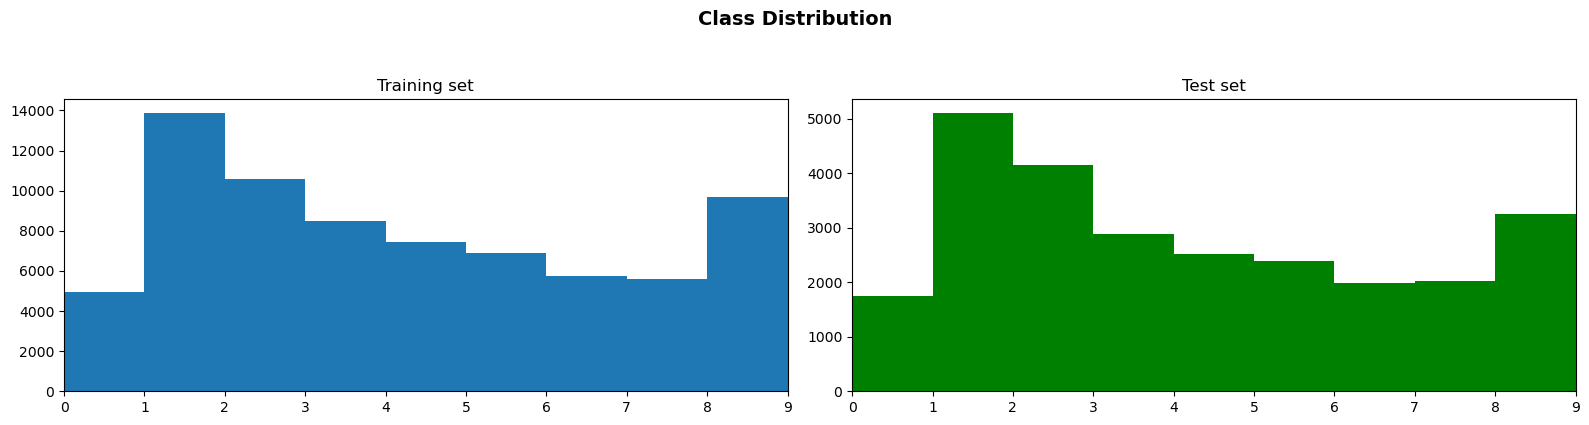

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True)

fig.suptitle('Class Distribution', fontsize=14, fontweight='bold', y=1.05)

ax1.hist(y_train, bins=9)
ax1.set_title("Training set")
ax1.set_xlim(0,9)

ax2.hist(y_test, color='g', bins=9)
ax2.set_title("Test set")

fig.tight_layout()

Convert the images to grayscale

In [17]:
train_greyscale = rgb2gray(X_train).astype(np.float32)
test_greyscale = rgb2gray(X_test).astype(np.float32)
print("Training Set", train_greyscale.shape)
print("Test Set", test_greyscale.shape)
print('')

Training Set (73257, 32, 32, 1)
Test Set (26032, 32, 32, 1)



Delete the two original images arrays from ram

In [18]:
del X_train, X_test

Plotting some grayscale train images

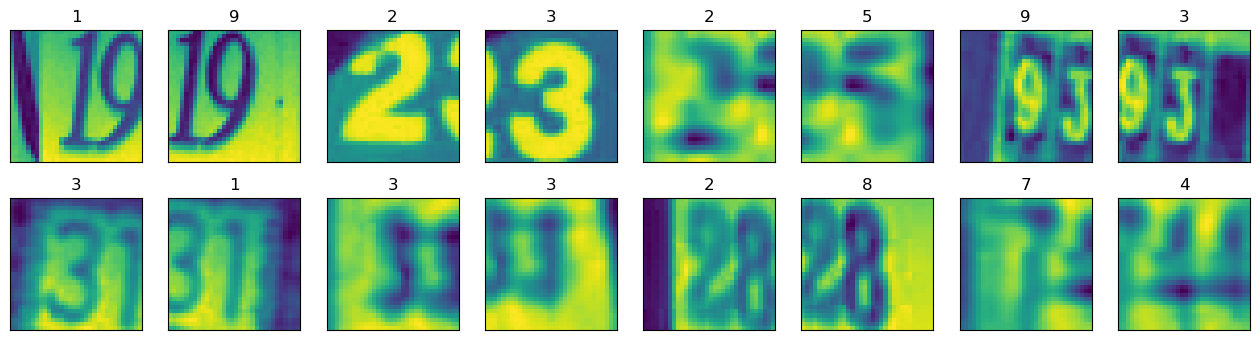

In [19]:
plot_images(train_greyscale, y_train, 2, 8)

Plotting some grayscale test images

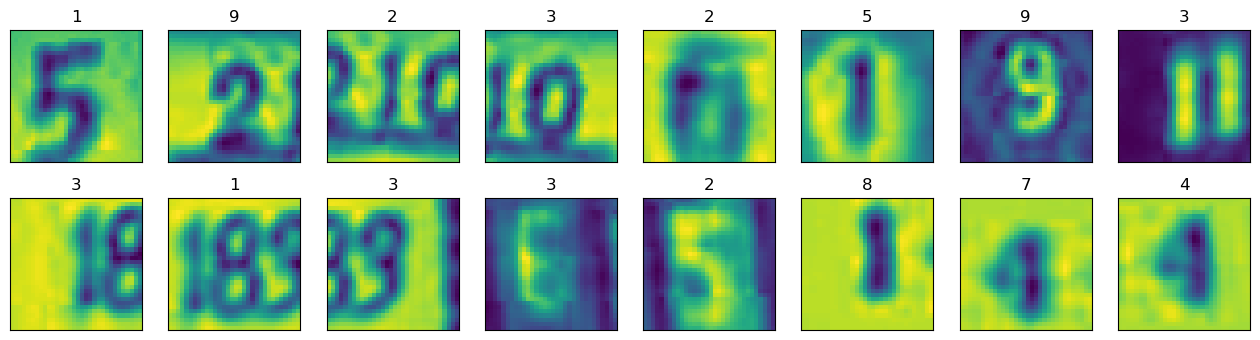

In [20]:
plot_images(test_greyscale, y_train, 2, 8)

Normalising the data

In [21]:
# Calculate the mean on the training data
train_mean = np.mean(train_greyscale, axis=0)

# Calculate the std on the training data
train_std = np.std(train_greyscale, axis=0)

# Subtract it equally from all splits
train_greyscale_norm = (train_greyscale - train_mean) / train_std
test_greyscale_norm = (test_greyscale - train_mean)  / train_std

Plotting some normalised grayscale train images

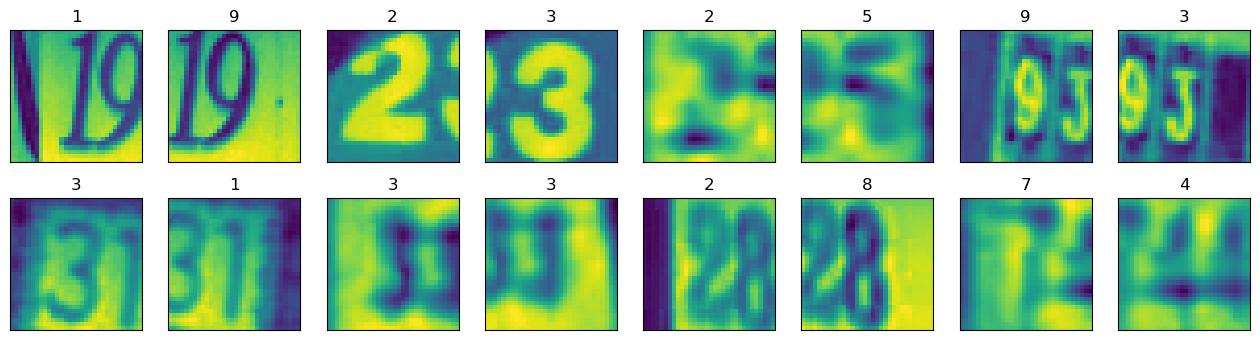

In [22]:
plot_images(train_greyscale_norm, y_train, 2, 8)

Plotting some normalised grayscale test images

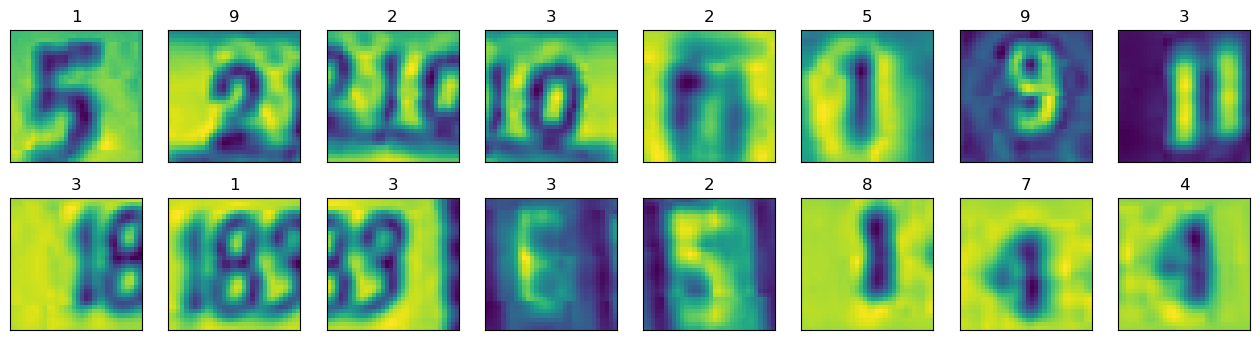

In [23]:
plot_images(test_greyscale_norm, y_train, 2, 8)

One hot encoding the labels to convert them from categorical to numerical

In [24]:
enc = OneHotEncoder().fit(y_train.reshape(-1, 1))

y_train = enc.transform(y_train.reshape(-1, 1)).toarray()
y_test = enc.transform(y_test.reshape(-1, 1)).toarray()

print("Training set", y_train.shape)
print("Test set", y_test.shape)

Training set (73257, 10)
Test set (26032, 10)


Storing the grascale data to a file for use in training

In [25]:
h5f = h5py.File('SVHN_grey.h5', 'w')
h5f.create_dataset('X_train', data=train_greyscale_norm)
h5f.create_dataset('y_train', data=y_train)
h5f.create_dataset('X_test', data=test_greyscale_norm)
h5f.create_dataset('y_test', data=y_test)
h5f.close()

In [26]:
h5f = h5py.File('SVHN_grey.h5', 'r')

# Load the training, test and validation set
train_images = h5f['X_train'][:]
train_labels = h5f['y_train'][:]
X_test = h5f['X_test'][:]
y_test = h5f['y_test'][:]

# Close this file
h5f.close()

print('Training set', train_images.shape, train_labels.shape)
print('Test set', X_test.shape, y_test.shape)

Training set (73257, 32, 32, 1) (73257, 10)
Test set (26032, 32, 32, 1) (26032, 10)


In [27]:
datagen = ImageDataGenerator(rotation_range=8,
                             zoom_range=[0.95, 1.05],
                             height_shift_range=0.10,
                             shear_range=0.15)

In [28]:
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels,
                                                  test_size=0.15, random_state=22)

In [29]:
keras.backend.clear_session()

model = keras.Sequential([
    
keras.layers.Conv2D(32, (3, 3), padding='same',
activation='relu',
input_shape=(32, 32, 1)),
keras.layers.BatchNormalization(),
    
keras.layers.Conv2D(64, (3, 3), padding='same',
activation='relu'),
keras.layers.MaxPooling2D((2, 2)),
keras.layers.Dropout(0.3),
    
keras.layers.Conv2D(128, (3, 3), padding='same',
activation='relu'),
keras.layers.BatchNormalization(),
    
keras.layers.Conv2D(128, (3, 3), padding='same',
activation='relu'),
keras.layers.MaxPooling2D((2, 2)),
keras.layers.Dropout(0.3),
    
keras.layers.Conv2D(128, (3, 3), padding='same',
activation='relu'),
keras.layers.BatchNormalization(),
    
keras.layers.Conv2D(128, (3, 3), padding='same',
activation='relu'),
keras.layers.MaxPooling2D((2, 2)),
keras.layers.Dropout(0.3),
keras.layers.Flatten(),
    
keras.layers.Dense(128, activation='relu'),
keras.layers.Dropout(0.4),
    
keras.layers.Dense(10, activation='softmax')
])
early_stopping = keras.callbacks.EarlyStopping(patience=8)

optimizer = keras.optimizers.Adam(learning_rate=1e-3, amsgrad=True)

model_checkpoint = keras.callbacks.ModelCheckpoint(
'best_cnn',
save_best_only=True)

model.compile(optimizer=optimizer,
loss='categorical_crossentropy',
metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       7

In [31]:
visualkeras.layered_view(model, to_file='output.png').show()

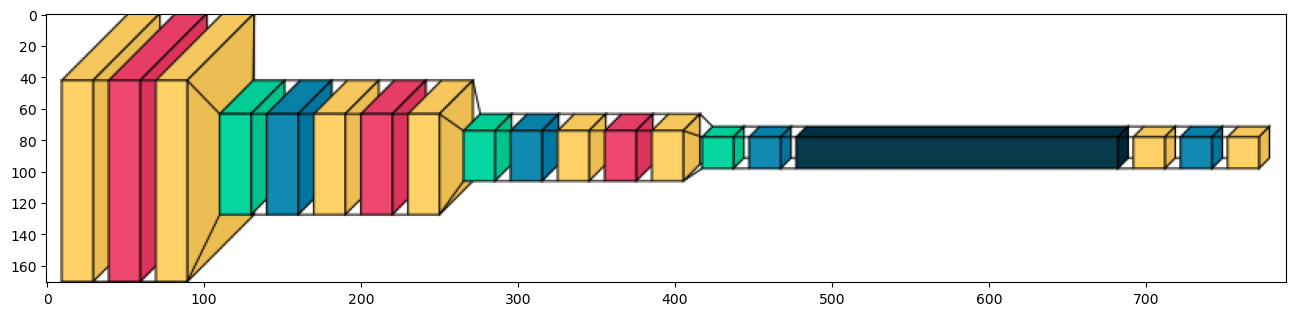

In [32]:
image = mpimg.imread("output.png")
plt.imshow(image)
plt.show()

In [33]:
start = time.time()
history = model.fit(datagen.flow(X_train, y_train, batch_size=128),
                              epochs=70, validation_data=(X_val, y_val),
                              callbacks=[early_stopping, model_checkpoint])
end = time.time()
print("CNN Fit Time: ", end - start,"s")

Epoch 1/70
487/487 [==============================] - ETA: 0s - loss: 2.1645 - accuracy: 0.2121INFO:tensorflow:Assets written to: best_cnn/assets


INFO:tensorflow:Assets written to: best_cnn/assets


487/487 [==============================] - 157s 308ms/step - loss: 2.1645 - accuracy: 0.2121 - val_loss: 1.6623 - val_accuracy: 0.4507
Epoch 2/70
487/487 [==============================] - ETA: 0s - loss: 1.4288 - accuracy: 0.4746INFO:tensorflow:Assets written to: best_cnn/assets


INFO:tensorflow:Assets written to: best_cnn/assets


487/487 [==============================] - 147s 301ms/step - loss: 1.4288 - accuracy: 0.4746 - val_loss: 0.6447 - val_accuracy: 0.8271
Epoch 3/70
487/487 [==============================] - ETA: 0s - loss: 0.7944 - accuracy: 0.7360INFO:tensorflow:Assets written to: best_cnn/assets


INFO:tensorflow:Assets written to: best_cnn/assets


487/487 [==============================] - 146s 299ms/step - loss: 0.7944 - accuracy: 0.7360 - val_loss: 0.3646 - val_accuracy: 0.8965
Epoch 4/70
487/487 [==============================] - ETA: 0s - loss: 0.4660 - accuracy: 0.8659INFO:tensorflow:Assets written to: best_cnn/assets


INFO:tensorflow:Assets written to: best_cnn/assets


487/487 [==============================] - 144s 295ms/step - loss: 0.4660 - accuracy: 0.8659 - val_loss: 0.2981 - val_accuracy: 0.9189
Epoch 5/70
487/487 [==============================] - ETA: 0s - loss: 0.3824 - accuracy: 0.8927INFO:tensorflow:Assets written to: best_cnn/assets


INFO:tensorflow:Assets written to: best_cnn/assets


487/487 [==============================] - 144s 296ms/step - loss: 0.3824 - accuracy: 0.8927 - val_loss: 0.2494 - val_accuracy: 0.9314
Epoch 6/70
487/487 [==============================] - ETA: 0s - loss: 0.3402 - accuracy: 0.9038INFO:tensorflow:Assets written to: best_cnn/assets


INFO:tensorflow:Assets written to: best_cnn/assets


487/487 [==============================] - 144s 296ms/step - loss: 0.3402 - accuracy: 0.9038 - val_loss: 0.2351 - val_accuracy: 0.9362
Epoch 7/70
487/487 [==============================] - ETA: 0s - loss: 0.3124 - accuracy: 0.9124INFO:tensorflow:Assets written to: best_cnn/assets


INFO:tensorflow:Assets written to: best_cnn/assets


487/487 [==============================] - 146s 299ms/step - loss: 0.3124 - accuracy: 0.9124 - val_loss: 0.2252 - val_accuracy: 0.9381
Epoch 8/70
487/487 [==============================] - ETA: 0s - loss: 0.2942 - accuracy: 0.9174INFO:tensorflow:Assets written to: best_cnn/assets


INFO:tensorflow:Assets written to: best_cnn/assets


487/487 [==============================] - 144s 296ms/step - loss: 0.2942 - accuracy: 0.9174 - val_loss: 0.2235 - val_accuracy: 0.9420
Epoch 9/70
487/487 [==============================] - ETA: 0s - loss: 0.2752 - accuracy: 0.9232INFO:tensorflow:Assets written to: best_cnn/assets


INFO:tensorflow:Assets written to: best_cnn/assets


487/487 [==============================] - 146s 300ms/step - loss: 0.2752 - accuracy: 0.9232 - val_loss: 0.2063 - val_accuracy: 0.9459
Epoch 10/70
487/487 [==============================] - ETA: 0s - loss: 0.2629 - accuracy: 0.9264INFO:tensorflow:Assets written to: best_cnn/assets


INFO:tensorflow:Assets written to: best_cnn/assets


487/487 [==============================] - 144s 296ms/step - loss: 0.2629 - accuracy: 0.9264 - val_loss: 0.2020 - val_accuracy: 0.9476
Epoch 11/70
487/487 [==============================] - 141s 290ms/step - loss: 0.2514 - accuracy: 0.9283 - val_loss: 0.2093 - val_accuracy: 0.9453
Epoch 12/70
487/487 [==============================] - 141s 289ms/step - loss: 0.2354 - accuracy: 0.9335 - val_loss: 0.2090 - val_accuracy: 0.9468
Epoch 13/70
487/487 [==============================] - 142s 291ms/step - loss: 0.2263 - accuracy: 0.9359 - val_loss: 0.2066 - val_accuracy: 0.9485
Epoch 14/70
487/487 [==============================] - ETA: 0s - loss: 0.2198 - accuracy: 0.9378INFO:tensorflow:Assets written to: best_cnn/assets


INFO:tensorflow:Assets written to: best_cnn/assets


487/487 [==============================] - 146s 299ms/step - loss: 0.2198 - accuracy: 0.9378 - val_loss: 0.1948 - val_accuracy: 0.9506
Epoch 15/70
487/487 [==============================] - ETA: 0s - loss: 0.2138 - accuracy: 0.9398INFO:tensorflow:Assets written to: best_cnn/assets


INFO:tensorflow:Assets written to: best_cnn/assets


487/487 [==============================] - 146s 301ms/step - loss: 0.2138 - accuracy: 0.9398 - val_loss: 0.1921 - val_accuracy: 0.9502
Epoch 16/70
487/487 [==============================] - 144s 295ms/step - loss: 0.2031 - accuracy: 0.9430 - val_loss: 0.2055 - val_accuracy: 0.9477
Epoch 17/70
487/487 [==============================] - ETA: 0s - loss: 0.2016 - accuracy: 0.9435INFO:tensorflow:Assets written to: best_cnn/assets


INFO:tensorflow:Assets written to: best_cnn/assets


487/487 [==============================] - 146s 301ms/step - loss: 0.2016 - accuracy: 0.9435 - val_loss: 0.1890 - val_accuracy: 0.9514
Epoch 18/70
487/487 [==============================] - 143s 294ms/step - loss: 0.1948 - accuracy: 0.9444 - val_loss: 0.2016 - val_accuracy: 0.9508
Epoch 19/70
487/487 [==============================] - 143s 295ms/step - loss: 0.1892 - accuracy: 0.9460 - val_loss: 0.1947 - val_accuracy: 0.9500
Epoch 20/70
487/487 [==============================] - 143s 294ms/step - loss: 0.1824 - accuracy: 0.9479 - val_loss: 0.1966 - val_accuracy: 0.9535
Epoch 21/70
487/487 [==============================] - 143s 293ms/step - loss: 0.1772 - accuracy: 0.9497 - val_loss: 0.2025 - val_accuracy: 0.9524
Epoch 22/70
487/487 [==============================] - 143s 294ms/step - loss: 0.1760 - accuracy: 0.9492 - val_loss: 0.1969 - val_accuracy: 0.9531
Epoch 23/70
487/487 [==============================] - 144s 295ms/step - loss: 0.1680 - accuracy: 0.9514 - val_loss: 0.2034 - val_

In [34]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

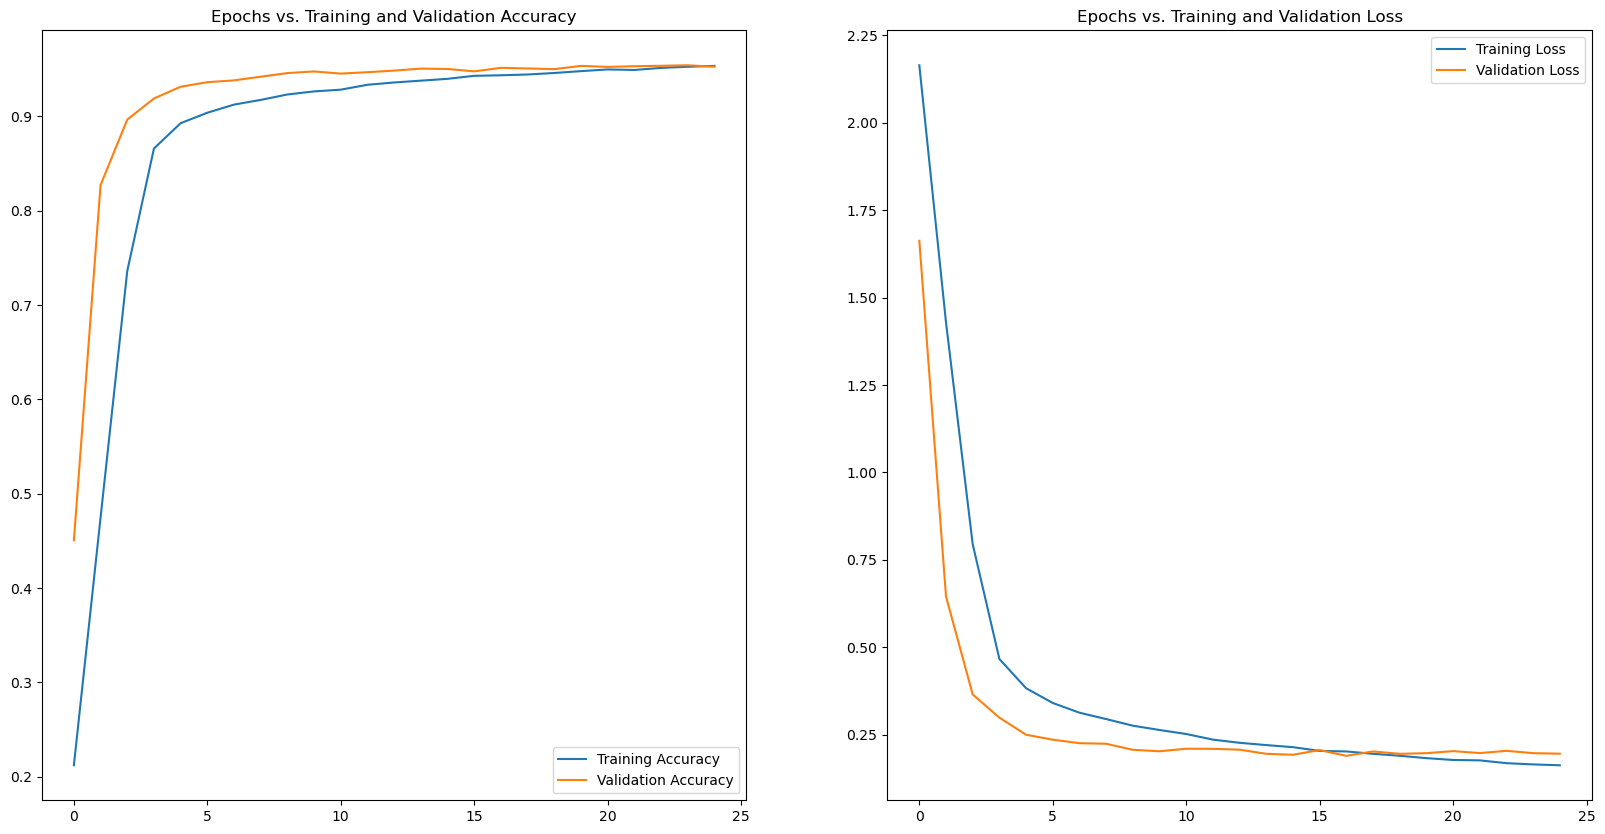

In [35]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Epochs vs. Training and Validation Accuracy')
    
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Epochs vs. Training and Validation Loss')

plt.show()

In [36]:
model.load_weights('best_cnn')

In [37]:
test_loss, test_acc = model.evaluate(x=X_test, y=y_test, verbose=0)
print('Test accuracy is: {:0.4f} \nTest loss is: {:0.4f}'.
      format(test_acc, test_loss))

Test accuracy is: 0.9610 
Test loss is: 0.1645


In [38]:
start = time.time()
x_test = X_test
y_true = y_test
y_pred = model.predict(x_test)
y_true_classes = np.argmax(y_true, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)
end = time.time()
print("CNN Predict Time: ", end - start,"s")

814/814 [==============================] - 16s 19ms/step
CNN Predict Time:  16.836565256118774 s


Confusion matrix, without normalization
[[1673   12    3    5    2    4   19    3   13   10]
 [  14 4982   19   18   23    6   10   19    7    1]
 [   4   22 4036   42   12    4    3   15    5    6]
 [   4   33   19 2711    7   32    2    2   26   46]
 [   3   31    6    7 2466    2    0    3    4    1]
 [   2    9    7   37    6 2268   33    3   12    7]
 [  13   11    2    4    6   23 1894    3   18    3]
 [   1   48   22   13    3    0    1 1927    3    1]
 [   5    9    8   13    6    3   45    1 1561    9]
 [  28   14   19   12    9    3    0    2    9 1499]]


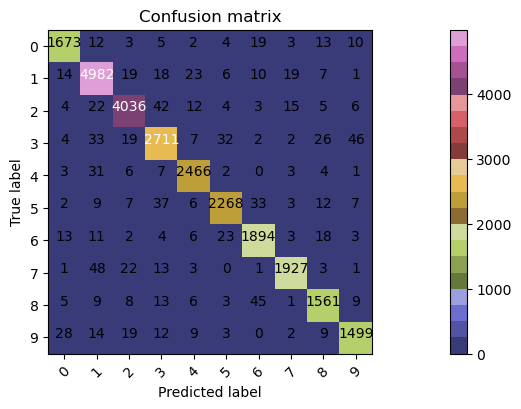

In [39]:
cm = metrics.confusion_matrix(y_true_classes, y_pred_classes)
plot_confusion_matrix(cm, ["0","1","2","3","4","5","6","7","8","9"]) 

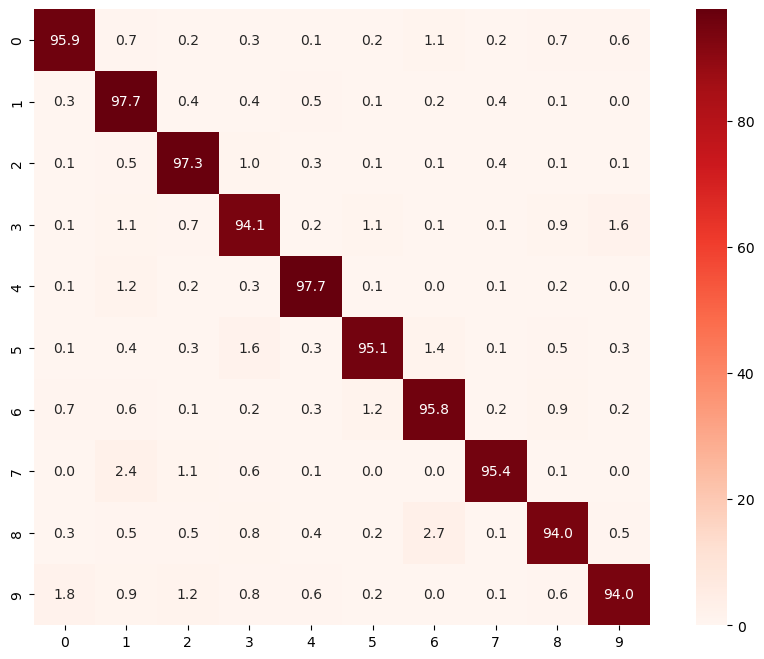

In [40]:
plt.figure(figsize=(12, 8))
cm = confusion_matrix(y_true=np.argmax(y_test, axis=1), y_pred=y_pred_classes)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100.00
sns.heatmap(cm, annot=True, cmap='Reds', fmt='.1f', square=True);

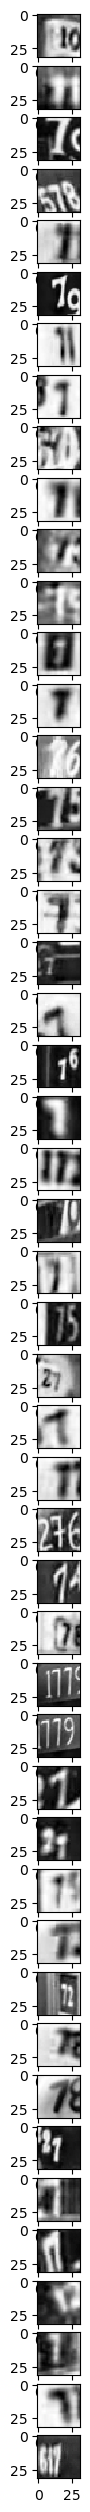

In [49]:
idx = np.where((y_pred_classes == 1) & (y_true_classes == 7))[0]
fig = plt.figure(figsize=(32,32))
for i in range(len(idx)):
    ax = fig.add_subplot(len(idx),1 , i + 1)
    imgplot = ax.imshow(np.reshape(x_test[idx[i],:], (32,32)), cmap=mpl.colormaps['Greys'])
    imgplot.set_interpolation("nearest")
plt.show()